<a href="https://colab.research.google.com/github/dpostolovski/eeg_is/blob/train_compare_full_data/(-_-)%20v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <img alt="FINKI **LOGO**" height="auto" src="https://www.finki.ukim.mk/Content/dataImages/downloads/logo-large-500x500_2.png" hspace="10px" vspace="0px">
  <h1>
    Интелигентни системи - Лабораториска вежба
  </h1>

  <h3><i>Група 5</i></h3>
  <h4><i>Дамjан Постоловски, Стефан Тодоровски, Ангела Кралевска, Иван Крстев, Мариjа Величковска</i></h2>
</center>

---



# 1. Подготовка на околината

In [ ]:
#@title 1.1 Монтирање на Google Drive податочниот систем
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title 1.2 Инсталирање, вчитување и иницијализација на потребните библиотеки
!pip install mne 
!pip install termcolor

%tensorflow_version 1.12.0

import os
import numpy as np
import mne

from sklearn import metrics 
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import to_categorical as to_cat
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from scipy.io import loadmat
from collections import Counter

%cd drive/My\ Drive/Интелигентни\ Системи
from EEGModels import DeepConvNet, EEGNet

!mkdir saved_models

K.set_image_data_format('channels_first')

# 2. Иницијализација на функции и константи

In [73]:
#@title 2.1 Иницијализација на константи
PARTICIPANT_START = 1 #@param {type:"integer"}
PARTICIPANT_END = 3 #@param {type:"integer"}
NUM_BATCH_SIZE=100 #@param {type:"integer"}
NUM_EPOCHS=150 #@param {type:"integer"}

## 2. Иницијализација на функции кои ќе ги користиме
1. load_mat_data - ги вчитува .mat податоците.
2. load_txt_data - ги вчитува .txt податоците.
3. load_data - ги повикува претходните две функции и ги вчитува податоците за даден учесник.
4. reshape -
5. reshape_data_to_mne_format -





In [74]:
def load_mat_data(folder_path, file_name, mode = 'Train'):
    """
        Load and concatenate train mat data from all three sessions.

        :param folder_path: path to the participant data
        :param file_name: the name of the mat file to be loaded (without .mat extension)
        :param mode: Train or Test data 
        :return: numpy array containing the mat data
    """
    data = np.empty(0)
    for session in range(1, 4):  # Итерација низ секоја сесија
        path = folder_path + '/S' + format(session, '02') + '/' + mode + '/' + file_name + '.mat'
        temp = loadmat(path)[file_name]
        if data.size != 0:
            data = np.concatenate((data, temp), axis=2)
        else:
            data = np.array(temp)
    return data


def load_txt_data(folder_path, file_name, mode = 'Train'):
    """
        Load and concatenate txt data from all three sessions.

        :param folder_path: path to the participant data
        :param file_name: the name of the file to be loaded
        :param mode: Train or Test data 
        :return: numpy array containing the wanted data
    """
    data = np.empty(0)
    for session in range(1, 4):  # Итерација низ секоја сесија
        path = folder_path + '/S' + format(session, '02') + '/' + mode + '/' + file_name
        with open(path, "r") as file:
            temp = file.read().splitlines()
            if file_name == 'trainLabels.txt':
                temp = np.repeat(temp, 8 * 10)
            if data.size != 0:
                data = np.concatenate((data, temp))
            else:
                data = np.array(temp)
    return data


def load_data(participant):
    """
        Load data for the given participant.

        :param participant: Participant number (1-15)
        :return: train_data, train_labels, train_events, train_targets
    """
    print("Вчитување податоци од испитниот примерок (учесник) " + str(participant) + '...')
    path_to_data = 'Data/SBJ' + format(participant, '02')

    train_data = load_mat_data(path_to_data, 'trainData')
    train_labels = load_txt_data(path_to_data, 'trainLabels.txt')
    train_events = load_txt_data(path_to_data, 'trainEvents.txt')
    train_targets = load_txt_data(path_to_data, 'trainTargets.txt')

    print("Податоците од испитниот примерок (учесник) " + str(participant) + " се вчитани.\n")
    return train_data, train_labels, train_events, train_targets


def load_test_data(participant):
    """
        Load test data for the given participant.

        :param participant: Participant number (1-15)
        :return: test_date, test_events
    """
    print("Вчитување тест податоци од испитниот примерок (учесник) " + str(participant) + '...')
    path_to_data = 'Data/SBJ' + format(participant, '02')

    test_date = load_mat_data(path_to_data, 'testData', 'Test')
    test_events = load_txt_data(path_to_data, 'testEvents.txt', 'Test')

    print("Тест податоците од испитниот примерок (учесник) " + str(participant) + " се вчитани.\n")
    return test_date, test_events


def reshape(data, labels, events, targets):
  mne_array = np.swapaxes(data, 0, 2) # (епохa, канал, настан). 
  mne_array = np.swapaxes(mne_array, 1, 2) # (епохa, канал, настан). 
  mne_array = mne_array.reshape(mne_array.shape[0], 1, 8, 350)

  labels_arr = labels.astype(np.int)
  events_arr = events.astype(np.int)
  return mne_array, labels_arr-1, events_arr-1


def reshape_data_to_mne_format(data):
  mne_array = np.swapaxes(data, 0, 2) # (епохa, канал, настан). 
  mne_array = np.swapaxes(mne_array, 1, 2) # (епохa, канал, настан). 
  mne_array = mne_array.reshape(mne_array.shape[0], 1, 8, 350)

  return mne_array

def load_runs_per_block(participant):
  test_runs_per_block = [[i for i in range(3)] for j in range(15)] # Covek, Sesija

  file_name = 'Data/SBJ' + format(participant, '02')
  for j in range(1, 4): # Итерација низ секоја сесија
    file_test_set = 'S' + format(j, '02') + '/Test'

    # Вчитување на бројот на runs 
    full_path = file_name + "/" + file_test_set + "/runs_per_block.txt"
    with open(full_path, "r") as runs_per_block:
      test_runs_per_block[participant-1][j-1] = int(runs_per_block.read())
  
  return test_runs_per_block

def print_test_data_info(participant, test_data, test_events, runs_per_block, predictions):
  index = participant - PARTICIPANT_START  

  print("SBJ" + str(format(participant, '02')) + "| Test_data: " + str(test_data[index].shape)) # test_data to predict
  print("SBJ" + str(format(participant, '02')) + "| Test_events: " + str(len(test_events))) # test_events
  for session in range (1,4):
    print("SBJ" + str(format(participant, '02')) + " / S" + str(format(session, '02')) + "| Runs per block: " + str(runs_per_block[participant-1][session-1])) # runs per block in SJB01, SJ00 
  print("SBJ" + str(format(participant, '02')) + "| Predictions: " + str(len(predictions)) + '\n')

# 3. Визуелизација

Creating RawArray with float64 data, n_channels=65, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


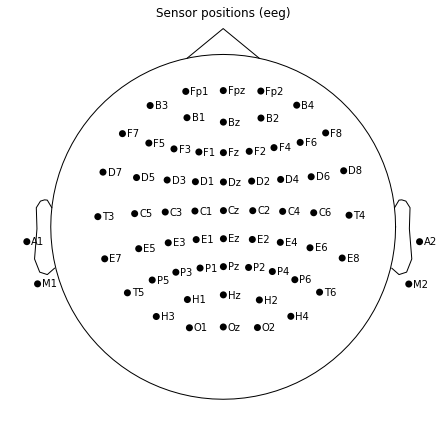

In [40]:
#@title 3.1 Локација на сензорите
#@markdown Може да се забележи дека каналите кои ги отчитуваме се наоѓаат во средниот и задниот дел на мозокот.
montage = mne.channels.make_standard_montage("standard_alphabetic")
montage.plot();

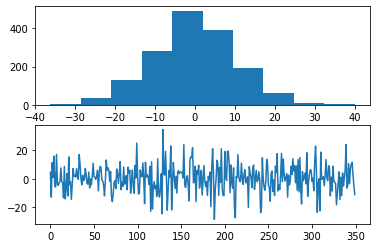

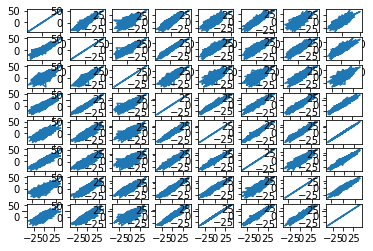

In [58]:
#@title 3.2 Histogram и зависности помеѓу 8те канали
from scipy import io
import matplotlib.pyplot as plt
t = io.loadmat('Data/SBJ01/S01/Train/trainData.mat')['trainData'] 
t[0].shape

fig, axs = plt.subplots(2)
# plot histogram
axs[0].hist(t[0][3])
axs[1].plot(range(0,350), t[0][2][0:350])

k = 0
fig, axs = plt.subplots(8,8)
for i in range(8):
  for y in range(8):
    axs[i,y].plot(t[i][0], t[y][0])

## 3.3 Визуелизација на податоците

NameError: ignored

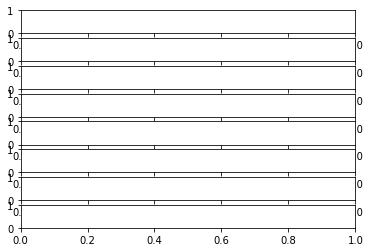

In [59]:
#@title 3.3.1 Визуелизација на EEG сигналите во рамки на еден настан (првиот настан).
fig, axs = plt.subplots(8)
swapped_matrix = np.swapaxes(data, 1, 2) # (канал, настан, епоха).

for channel in range(0, 8):
  axs[channel].set_title(ch_names[channel])
  for epoch in range(0, 350):
    y_arr = data[channel][epoch][0]
    axs[channel].plot(range(0,350), swapped_matrix[channel][0])

In [60]:
#@title 3.3.2 Визуелизација на EEG сигналите во првата,средната и последната епоха.
#@markdown 1. Визуелизација на EEG податоците по канали за првата, средната и последната епоха.
#@markdown 2. Power Spectrum Density на 175-тата епоха. Во оваа епоха 
#@markdown сигналите би биле најстабилни за објектот кој светка.

middle_epoch = mne_array[175]
first_epoch = mne_array[0]
last_epoch = mne_array[349]
raw_middle = mne.io.RawArray(middle_epoch, mne_info)
raw_first = mne.io.RawArray(first_epoch, mne_info)
raw_last = mne.io.RawArray(last_epoch, mne_info)
for epoch in range(0, 350): # Секоја епоха
  i = 0
  for event in range(0, 1600): # Настан
    
    np.array([1, 2, 3])
    i = i+1



print("\n")
print(colored('====== 1 ======', 'red'))
print(colored("Прва епоха од сите 1600 настани", 'blue'))
raw_first.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'))
print(colored("Средна епоха од сите 1600 настани", 'blue'))
raw_middle.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'))
print(colored("Последна епоха од сите 1600 настани", 'blue'))
raw_last.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'))
print("\n")
print(colored('====== 2 ======', 'red'))
raw_middle.plot_psd(area_mode='range', show=False, average=True);
raw_data.plot_image();

NameError: ignored

In [61]:
#@title 3.3.3 Визуелна споредба на EEG податоците при светкање на првиот и последниот објект  
#@markdown Во првиот случај вршиме споредба на EEG податоците кога првиот и последниот 
#@markdown објект светнал без разлика дали бил target, додека во вториот случај ги споредуваме
#@markdown EEG податоците за случаи само кога тие објекти биле target објекти.

# Извлекување на настаните каде светнал првиот објект.
first_object_events = [index for index, value in enumerate(events_arr) if value == '1']
first_object_eeg_data = np.zeros((8,350, len(first_object_events)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in first_object_events: # Настан
      first_object_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_first_obj_array = np.swapaxes(first_object_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_first_obj_array[175] 
first_object_raw = mne.io.RawArray(epoch, mne_info)





# Извлекување на настаните каде светнал првиот објект и бил target.
first_object_events_target = [index for index, value in enumerate(events_arr) if value == '1']
for event_pos in first_object_events_target:
  if targets_arr[event_pos] == 1:
    continue # Продолжи
  else:
    first_object_events_target.remove(event_pos) # Избриши -> Објектот не е target
first_object_target_eeg_data = np.zeros((8,350, len(first_object_events_target)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in first_object_events_target: # Настан
      first_object_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_first_obj_target_array = np.swapaxes(first_object_target_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_first_obj_target_array[175] 
first_object_target_raw = mne.io.RawArray(epoch, mne_info)





# Извлекување на настаните каде светнал последниот објект.
last_object_events = [index for index, value in enumerate(events_arr) if value == '8']
last_object_eeg_data = np.zeros((8,350, len(last_object_events)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in last_object_events: # Настан
      last_object_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_last_obj_array = np.swapaxes(last_object_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_last_obj_array[175] 
last_object_raw = mne.io.RawArray(epoch, mne_info)





# Извлекување на настаните каде светнал последниот објект и бил target.
last_object_events_target = [index for index, value in enumerate(events_arr) if value == '8']
for event_pos in last_object_events_target:
  if targets_arr[event_pos] == 1:
    continue # Продолжи
  else:
    last_object_events_target.remove(event_pos) # Избриши -> Објектот не е target
last_object_target_eeg_data = np.zeros((8,350, len(last_object_events_target)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in last_object_events_target: # Настан
      last_object_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1
      
# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_last_obj_target_array = np.swapaxes(last_object_target_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_last_obj_target_array[175] 
last_object_target_raw = mne.io.RawArray(epoch, mne_info)

# Исцртување и печатење
print("\n\n")
print(colored('====== ПРВ ОБЈЕКТ - Книги на полица ======', 'red'))
print(colored("Вкупно светнал: " + str(len(first_object_events)), 'blue'))
print(colored("Вкупно светнал и бил target: " + str(len(first_object_events_target)), 'blue'))
print("\n")
print(colored('====== ПОСЛЕДЕН ОБЈЕКТ - Слика закачена на ѕид ======', 'red'))
print(colored("Вкупно светнал: " + str(len(last_object_events)), 'blue'))
print(colored("Вкупно светнал и бил target: " + str(len(last_object_events_target)), 'blue'))
print("\n")
print(colored('====== Графици со EEG податоци кога светнале првиот и последниот објект  ======', 'green'))
first_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
last_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
print("\n")
print(colored('====== Графици со EEG податоци кога светнале првиот и последниот објект и биле target  ======', 'green'))
first_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
last_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));

NameError: ignored

In [ ]:
from mne.preprocessing import ICA
raw.plot_psd(tmin=0.2, tmax=1.2, fmin=0, fmax=60, average=True, spatial_colors=False);
num_components = 8
ica = ICA(n_components=num_components, method='fastica')
ica.fit(raw)
ica.plot_sources(raw);

# 4. Претпроцесирање

In [ ]:
#@title 4.1 Стандардизација на податоците

standardizer = mne.decoding.Scaler(scalings='mean')
standardizer.fit(mne_array)
standardized_data = standardizer.transform(mne_array)
print("Просекот е:",-round(standardized_data.mean()))
print("Варијансата е:",round(standardized_data.var()))

In [ ]:
#@title 4.2 Нормализација метод бр. 2


import numpy as np
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def min_max_scale(dataset: np.ndarray) -> np.ndarray:
    scaler = MinMaxScaler(feature_range=[0, 1])
    scaled_data = scaler.fit_transform(dataset)
    return scaled_data

def standard_scale(dataset: np.ndarray) -> np.ndarray:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    return scaled_data

data = loadmat('drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainData.mat')['trainData'] 

v_min = data.min(axis=(0, 1), keepdims=True)
v_max = data.max(axis=(0, 1), keepdims=True)
print("Нормализирани податоци:")
(data - v_min)/(v_max - v_min)



In [ ]:
#@title 4.3 Отстранување на шум - претстава

Min, Max = round(mne_array.min()),round(mne_array.max())*1000000
picks = mne.pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False)
mne.viz.plot_epochs_image(raw_data, picks='eeg', vmin= Min, vmax=Max)


In [ ]:
#@title 4.4 Отстранување на шум - реултати
xd = mne.preprocessing.Xdawn(n_components=2, signal_cov=None)
xd.fit(raw_data)
epochs_denoised = xd.apply(raw_data)
epochs_denoised.keys()
mne.viz.plot_epochs_image(epochs_denoised['1'], picks='eeg', vmin=Min, vmax=Max)

In [ ]:
#@title 4.5 Downsampling
events = raw_data.events
epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=1, preload=True)
print(epochs)
# Downsample to 175 Hz
print('Original sampling rate:', epochs.info['sfreq'], 'Hz')
epochs_resampled = epochs.copy().resample(175, npad='auto')
print('New sampling rate:', epochs_resampled.info['sfreq'], 'Hz')

# Plot a piece of data to see the effects of downsampling
plt.figure(figsize=(7, 3))

n_samples_to_plot = int(0.5 * epochs.info['sfreq'])  # plot 0.5 seconds of data
plt.plot(epochs.times[:n_samples_to_plot],
         epochs.get_data()[ 0, 0, :n_samples_to_plot], color='black')

n_samples_to_plot = int(0.5 * epochs_resampled.info['sfreq'])
plt.plot(epochs_resampled.times[:n_samples_to_plot],
         epochs_resampled.get_data()[ 0, 0, :n_samples_to_plot],
         '-o', color='red')

plt.xlabel('time (s)')
plt.legend(['original', 'downsampled'], loc='best')
plt.title('Effect of downsampling')
mne.viz.tight_layout()

In [ ]:
#@title 4.6 Principal Component Analysis
pca = mne.decoding.UnsupervisedSpatialFilter(PCA(8), average=False)
pca_data = pca.fit_transform(mne_array)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(8, raw_data.info['sfreq'],
                                     ch_types='eeg'), tmin=Min)
ev.plot(show=False, window_title="PCA", time_unit='ms')

# 5. Тренирање на моделот
Тренирање на моделот

In [ ]:
# Глобална низа каде ќе се зачувуваат тренираните модели
models = []

for participant in range(PARTICIPANT_START, PARTICIPANT_END):  # Итерација низ секој испитен примерок
    train_data, train_labels, train_events, train_targets = load_data(participant)
    
    data, labels, events = reshape(train_data, train_labels, train_events, train_targets)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

    model = DeepConvNet(nb_classes = 8, Chans = 8, Samples = 350)
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer = Adam(0.0009))
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                                  verbose=1, save_best_only=True)

    y_train = to_cat(y_train)
    y_test = to_cat(y_test)

    model.fit(X_train, y_train, batch_size=NUM_BATCH_SIZE, epochs=NUM_EPOCHS, \
              validation_data=(X_test, y_test),callbacks=[checkpointer], verbose=1)

    score = model.evaluate(X_test, y_test, verbose=1)
    print(score)

    models.append(model) # Ke imame 15 modeli neli, pa vo niza se staveni
                        # pristap do niv model[i]

# 6. Тестирање на моделот

Тестирање на моделот

In [ ]:
# Иницијализација на променливите каде ќе бидат вчитани тест податоците
runs_per_block = [[i for i in range(3)] for j in range(15)] # Covek, Sesija

for participant in range(PARTICIPANT_START, PARTICIPANT_END): # Итерација низ секој испитен примерок
  print(f"============================================================ Учесник ({participant}) ============================================================")
  test_data, test_events = load_test_data(participant)
  runs_per_block = load_runs_per_block(participant)

  to_predict_data = reshape_data_to_mne_format(test_data)
  predictions = models[index].predict(to_predict_data)

  print_test_data_info(participant, test_data, test_events, runs_per_block, predictions)

  int_pred = np.argmax(predictions, axis=1)
  int_ytest = np.argmax(y_test, axis=1)

  session_start = 0
  start_prediction_index = 0
  end_prediction_index = 0
  for session in range(0, 3):
    print(f"Сесија ({session}): ", end='')
    for block in range(0, 50):    
      events_per_block = runs_per_block[participant-1][session]

      start_prediction_index = session_start + (block*events_per_block)*8
      end_prediction_index = session_start + ((block+1)*events_per_block)*8

      block_prediction = int_pred[start_prediction_index:end_prediction_index]
      prediction = np.bincount(block_prediction).argmax()

      if (block != 49):
        print(str(prediction) + ",", end="")
      else:
        print(str(prediction))  
    session_start = end_prediction_index
  print(f"============================================================ Учесник ({participant}) ============================================================\n\n")